<a href="https://colab.research.google.com/github/mia2465/PMLTermProject/blob/main/WORKINGCOPYthroughHistogramcvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

![CVAE image latent space](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cvae_latent_space.jpg?raw=1)

## Setup

In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
#!pip install pydicom

from google.colab import drive
drive.mount('/content/drive')

from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
#import pydicom
import pandas as pd
#import os
#import csv
#import pickle
#import keras



  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6vu18ml9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-6vu18ml9
  Resolved https://github.com/tensorflow/docs to commit 3eac15bae13ea389957e7eb499252ef5da6c9f01
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.4.30.68232-py3-none-any.whl size=182538 sha256=8388a23563e75ef9b91123e3ba574ccb8940604d63fca426db7944f5816cf557
  Stored in directory: /tmp/pip-ephem-wheel-cache-9qrhycj1/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
Mounted at /content/drive


In [2]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/AllDICOM/trainSet128')

In [3]:
test_dataset = tf.data.Dataset.load('/content/drive/MyDrive/AllDICOM/testSet128')

In [ ]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/AllDICOM/trainSet128Healthy')

In [ ]:
test_dataset = tf.data.Dataset.load('/content/drive/MyDrive/AllDICOM/testSet128Sick')

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [4]:
# For 98% data set
train_size =  8,718
batch_size = 32
test_size =  178

In [ ]:
# For healthy vs not
train_size =  5,915
batch_size = 32
test_size =  2,982

## Use *tf.data* to batch and shuffle the data

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.
Output log-variance instead of the variance directly for numerical stability.

### Decoder network
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [10]:
epochs = 3
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

### Display a generated image from the last training epoch

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

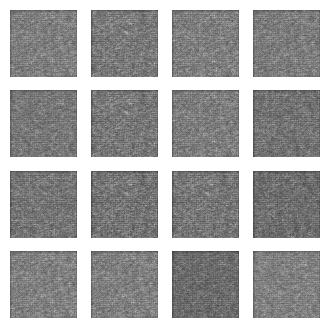

Epoch: 1, Test set ELBO: -8879.5751953125, time elapse for current epoch: 8.700449466705322


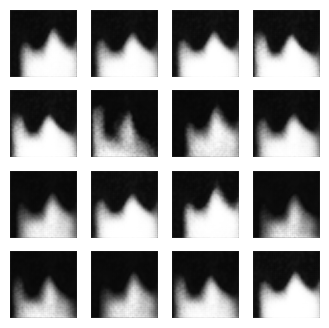

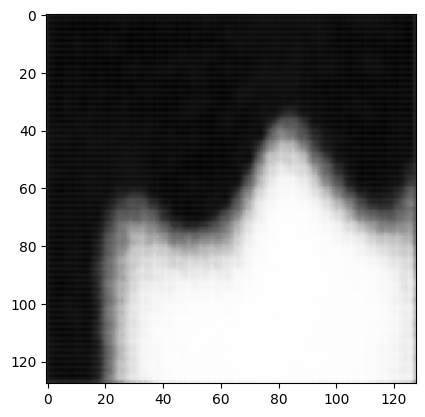

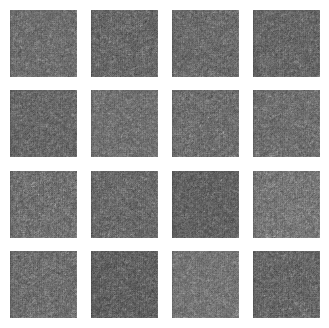

Epoch: 1, Test set ELBO: -7350.39697265625, time elapse for current epoch: 8.722330331802368


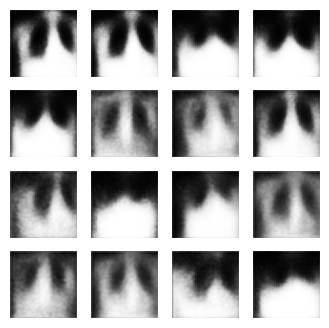

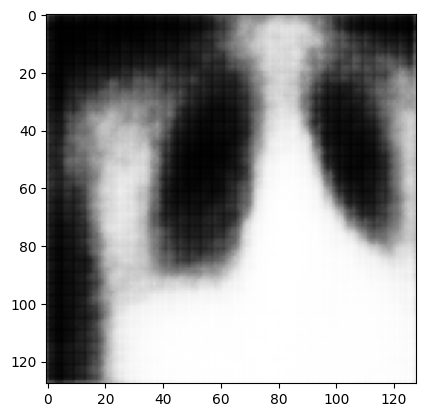

In [73]:


for latentVar in [2,8]:
  epochs = 1
  latent_dim = latentVar
  num_examples_to_generate = 16
  trainedModels = np.empty(2)

  #________MODEL___________
  class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
      super(CVAE, self).__init__()
      self.latent_dim = latent_dim
      self.encoder = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
      )

      self.decoder = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters=64, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=32, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=1, kernel_size=3, strides=1, padding='same'),
          ]
      )

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
      mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
      return mean, logvar

    def reparameterize(self, mean, logvar):
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits
  #________________
  optimizer = tf.keras.optimizers.Adam(1e-4)


  def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


  def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


  @tf.function
  def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
  model = CVAE(latent_dim)
  #_______________

  generate_and_save_images(model, 0, test_sample)

  for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
      train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

  #saveString = "/content/drive/MyDrive/AllDICOM/Model" + str(latentVar)+ ".keras"
  #model.build((128, 128, 1))
  #model.save(saveString)

  #OrigionalImages = origional_images(test_batch)
  batchSize = 31

  OrigionalImages = np.empty(shape=(batchSize, 128,128))
  VAEGeneratedImages = np.empty(shape=(batchSize, 128,128))
  #VAEAlteredImage = test_batch[0:batchSize, :, :,:].numpy()

  for imageNum in range(batchSize):
    #print('a')
    #print(str(imageNum))
    test_image = test_batch[imageNum, :, :,:].numpy()
    normalized_image = (test_image-np.min(test_image))/(np.max(test_image)-np.min(test_image))
    OrigionalImages[imageNum] = test_image.reshape((128, 128))
    #_________
    VAEAlteredImage = test_batch[imageNum:imageNum+1, :, :,:].numpy()
    #print(str(VAEAlteredImage.shape[0]))
    mean, logvar = model.encode(VAEAlteredImage)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    VAEGeneratedImages[imageNum] = tf.reshape(predictions[0], (128, 128))

  plt.imshow(OrigionalImages[0],cmap='Greys_r')
  plt.imshow( VAEGeneratedImages[0],cmap='Greys_r')


  #VAEGeneratedImages = vae_generated_images(model, test_size)
  #VAEAlteredImages = test_batch[0:batchSize, :, :,:].numpy()

  #mean, logvar = model.encode(VAEAlteredImages)
  #z = model.reparameterize(mean, logvar)
  #predictions = model.sample(z)
  #VAEGeneratedImages = tf.reshape(predictions[0], (128, 128))
  #lt.imshow(VAEGeneratedImages[0],cmap='Greys_r')

  #plt.imshow(results[0],cmap='Greys_r')


  #finalError = image_error_comparison(model, OrigionalImages, VAEGeneratedImages)

  totalError = np.empty(batchSize-1)
  for imageNum in range(batchSize -1 ):
    for col in range(128):
      for row in range(128):
        #print('b')
        #print(str(OrigionalImages[imageNum][col,row]))
        #print(str(VAEGeneratedImages[imageNum][col,row]))

        totalError[imageNum] += abs(OrigionalImages[imageNum][col,row] - VAEGeneratedImages[imageNum][col,row])
  np.save("/content/drive/MyDrive/AllDICOM/Model" + str(latentVar), totalError)




(-0.5, 399.5, 399.5, -0.5)

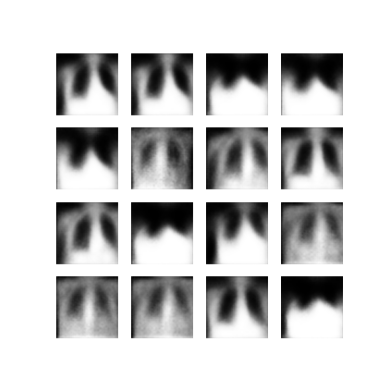

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-13-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-13-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



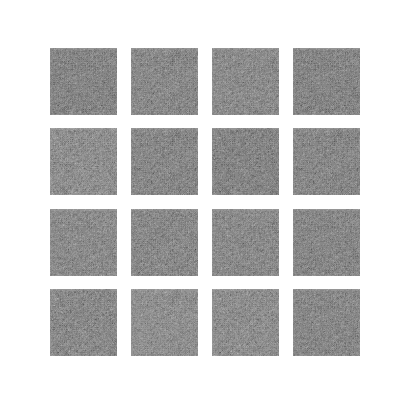

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [ ]:
def plot_latent_images(model, n, digit_size=128):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [ ]:
import keras
model = keras.models.load_model("/content/drive/MyDrive/AllDICOM/Model8.keras")

plot_latent_images(model, 20)

TypeError: Could not locate class 'CVAE'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'CVAE', 'config': {'latent_dim': 8}, 'registered_name': 'CVAE'}

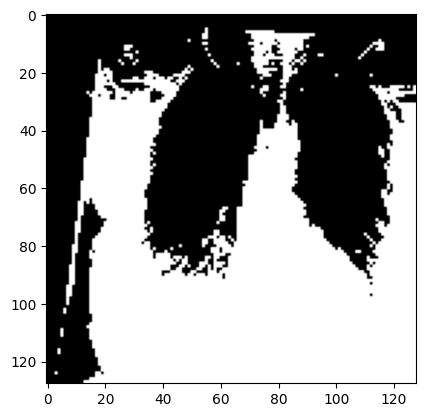

In [22]:

test_sample2 = test_batch[1, :, :,:].numpy()
hopefullyUndo2 = test_sample2.reshape((128, 128))
plt.imshow(hopefullyUndo2,cmap='Greys_r')

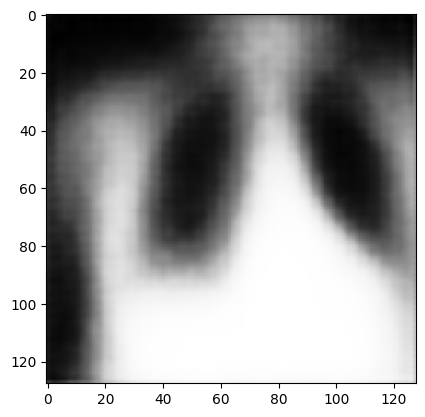

In [ ]:

test_sample2 = test_batch[0:1, :, :,:].numpy()
mean, logvar = model.encode(test_sample2)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)
results = tf.reshape(predictions[0], (128, 128))
plt.imshow(results,cmap='Greys_r')

In [15]:
def origional_images(test_batch):
  OrigionalImages = np.empty(test_size)
  for imageNum in range(test_size):
    test_image = test_batch[imageNum, :, :,:].numpy()
    normalized_image = (test_image-np.min(test_image))/(np.max(test_image)-np.min(test_image))
    OrigionalImages[imageNum] = test_sample.reshape((128, 128))
  return OrigionalImages
  #plt.imshow(OrigionalImages[0],cmap='Greys_r')

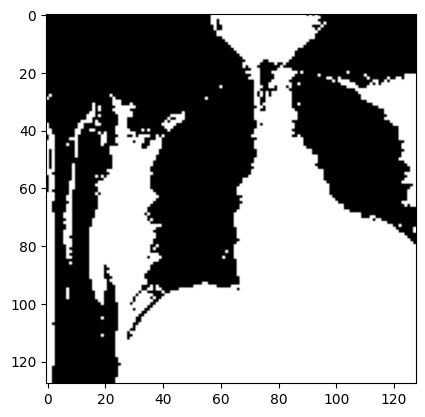

In [78]:
plt.imshow(OrigionalImages[0],cmap='Greys_r')

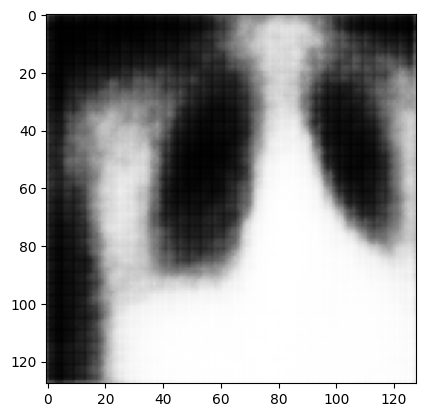

In [79]:
plt.imshow(VAEGeneratedImages[0],cmap='Greys_r')

In [16]:
def vae_generated_images(model, test_size):
  VAEAlteredImages = test_batch[0:test_size, :, :,:].numpy()
  mean, logvar = model.encode(VAEAlteredImages)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  results = tf.reshape(predictions[0], (128, 128))
  return results
  #plt.imshow(results[0],cmap='Greys_r')

In [17]:
def image_error_comparison(model, OrigionalImages, VAEImages):
  totalError = []
  for imageNum in range(31):
    for col in range(128):
      for row in range(128):
        totalError[imageNum] += abs(OrigionalImages[imageNum][col,row] - VAEImages[imageNum][col,row])
  return totalError

In [ ]:
OrigionalImages = np.empty(178)
for imageNum in range(178):
  test_sample = test_batch[imageNum, :, :,:].numpy()
  OrigionalImages[imageNum] = test_sample.reshape((128, 128))

origionalImages = (hopefullyUndo-np.min(hopefullyUndo))/(np.max(hopefullyUndo)-np.min(hopefullyUndo))
VAEIMages = (results-np.min(results))/(np.max(results)-np.min(results))
print(VAEIMages)
totalError = np.empty(1)

for imageNum in range(1):
  for col in range(128):
    for row in range(128):
      totalError[imageNum] += abs(origionalImages[col,row] - VAEIMages[col,row])

      #print(totalError[imageNum])


plt.hist(totalError, bins=30, color='skyblue', edgecolor='black')


(array([3., 3., 0., 1., 0., 2., 1., 3., 2., 3., 1., 3., 2., 2., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.]),
 array([ 1972.82171445,  2375.65683593,  2778.49195742,  3181.32707891,
         3584.1622004 ,  3986.99732189,  4389.83244338,  4792.66756487,
         5195.50268636,  5598.33780785,  6001.17292934,  6404.00805083,
         6806.84317231,  7209.6782938 ,  7612.51341529,  8015.34853678,
         8418.18365827,  8821.01877976,  9223.85390125,  9626.68902274,
        10029.52414423, 10432.35926572, 10835.19438721, 11238.02950869,
        11640.86463018, 12043.69975167, 12446.53487316, 12849.36999465,
        13252.20511614, 13655.04023763, 14057.87535912]),
 <BarContainer object of 30 artists>)

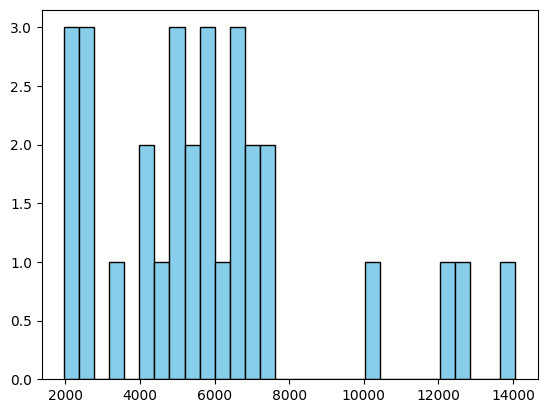

In [83]:
plt.hist(totalError, bins=30, color='skyblue', edgecolor='black')

(array([5., 2., 1., 2., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 2., 0., 1., 0., 1., 2., 0., 1., 4., 0., 1.]),
 array([4612.86845651, 4714.79345461, 4816.71845271, 4918.64345081,
        5020.56844892, 5122.49344702, 5224.41844512, 5326.34344322,
        5428.26844132, 5530.19343942, 5632.11843752, 5734.04343562,
        5835.96843372, 5937.89343182, 6039.81842992, 6141.74342802,
        6243.66842612, 6345.59342422, 6447.51842232, 6549.44342042,
        6651.36841852, 6753.29341663, 6855.21841473, 6957.14341283,
        7059.06841093, 7160.99340903, 7262.91840713, 7364.84340523,
        7466.76840333, 7568.69340143, 7670.61839953]),
 <BarContainer object of 30 artists>)

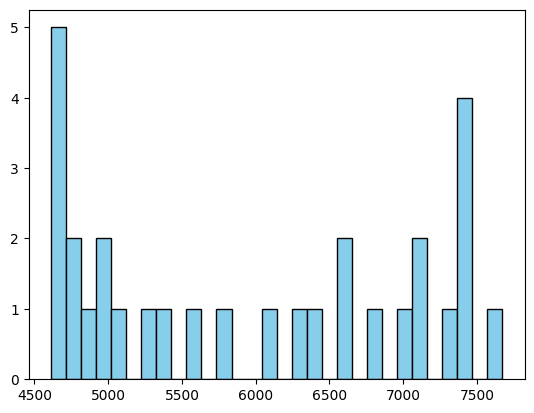

In [84]:
totalError = np.load("/content/drive/MyDrive/AllDICOM/Model2.npy")
plt.hist(totalError, bins=30, color='skyblue', edgecolor='black')

(array([3., 3., 0., 1., 0., 2., 1., 3., 2., 3., 1., 3., 2., 2., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.]),
 array([ 1972.82171445,  2375.65683593,  2778.49195742,  3181.32707891,
         3584.1622004 ,  3986.99732189,  4389.83244338,  4792.66756487,
         5195.50268636,  5598.33780785,  6001.17292934,  6404.00805083,
         6806.84317231,  7209.6782938 ,  7612.51341529,  8015.34853678,
         8418.18365827,  8821.01877976,  9223.85390125,  9626.68902274,
        10029.52414423, 10432.35926572, 10835.19438721, 11238.02950869,
        11640.86463018, 12043.69975167, 12446.53487316, 12849.36999465,
        13252.20511614, 13655.04023763, 14057.87535912]),
 <BarContainer object of 30 artists>)

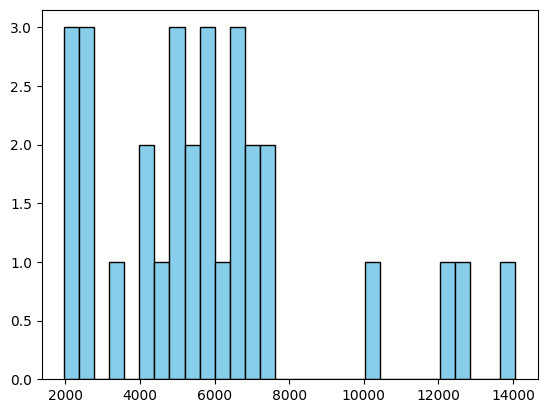

In [85]:
totalError = np.load("/content/drive/MyDrive/AllDICOM/Model8.npy")
plt.hist(totalError, bins=30, color='skyblue', edgecolor='black')

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow.

As a next step, you could try to improve the model output by increasing the network size.
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512.
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).